In [1]:
%matplotlib inline
import os
import sys
import lenspyx
from lenspyx.utils import camb_clfile,camb_clfile2
import matplotlib.pyplot as pl
import healpy as hp, numpy as np
import pickle as pk

In [2]:
sys.path.append('../')
from helper import clhash,hash_check #helper fuction for hashing a given Cls(multipoles)
import mpi

In [3]:
path = "Sims/CAMB/"
len_file = "BBSims_lensed_dls.dat"
unlen_file =  "BBSims_scal_dls.dat"
pot_file = "BBSims_lenspotential.dat"

In [4]:
class CMBLensed:
    """
    Lensing class:
    It saves seeds, Phi Map and Lensed CMB maps
    
    """
    def __init__(self,outfolder,nsim,cl_path,scal_file,pot_file,verbose=False):
        self.outfolder = outfolder
        self.cl_unl = camb_clfile2(os.path.join(cl_path, scal_file))
        self.cl_pot = camb_clfile2(os.path.join(cl_path, pot_file))
        self.nside = 2048
        self.lmax = 4096
        self.dlmax = 1024
        self.facres = 0
        self.verbose = verbose
        self.nsim = nsim
        
        if mpi.rank == 0:
            os.makedirs(self.outfolder,exist_ok=True)
            os.makedirs(os.path.join(self.outfolder,'MASS'),exist_ok=True) #folder for mass
            os.makedirs(os.path.join(self.outfolder,'CMB'),exist_ok=True) #folder for CMB
        
        self.seeds = self.get_seeds
        
        
        fname = os.path.join(self.outfolder,'seeds.pkl')
        if (not os.path.isfile(fname)) and (mpi.rank == 0):
            pk.dump(self.seeds, open(fname,'wb'), protocol=2)
        else:
            self.seeds = pk.load(open(fname,'rb'))
        
        
        # Here I saves a dictonary with the artibutes of this class and given Cls. 
        # So everytime when this instance run it checks for the same setup
        # If any artribute has changed from the previous run
        fnhash = os.path.join(self.outfolder, "lensing_sim_hash.pk")
        if (mpi.rank == 0) and (not os.path.isfile(fnhash)):
            pk.dump(self.hashdict(), open(fnhash, 'wb'), protocol=2)
        mpi.barrier()
        
        hash_check(pk.load(open(fnhash, 'rb')), self.hashdict())

    def hashdict(self):
        return {'nside':self.nside,
                'lmax':self.lmax,
                'nsim':self.nsim,
                'cl_ee': clhash(self.cl_unl['ee']),
                'cl_pp': clhash(self.cl_pot['pp']),
               }
    @property
    def get_seeds(self):
        """
        non-repeating seeds
        """
        seeds =[]
        no = 0
        while no <= self.nsim-1:
            r = np.random.randint(11111,99999)
            if r not in seeds:
                seeds.append(r)
                no+=1
        return seeds
    
    def vprint(self,string):
        if self.verbose:
            print(string)
                  
    def get_phi(self,idx):
        """
        set a seed
        generate phi_LM
        Save the phi
        """
        fname = os.path.join(self.outfolder,'MASS',f"phi_sims_{idx:04d}.fits")
        if os.path.isfile(fname):
            self.vprint(f"Phi field from cache: {idx}")
            return hp.read_alm(fname)
        else:
            np.random.seed(self.seeds[idx])
            plm = hp.synalm(self.cl_pot['pp'], lmax=self.lmax + self.dlmax, new=True)
            hp.write_alm(fname,plm)
            self.vprint(f"Phi field cached: {idx}")
            return plm
        
    def get_kappa(self,idx):
        """
        generate deflection field
        sqrt(L(L+1)) * \phi_{LM}
        """
        der = np.sqrt(np.arange(self.lmax + 1, dtype=float) * np.arange(1, self.lmax + 2))
        return hp.almxfl(self.get_phi(idx), der)
    
    def get_unlensed_alm(self,idx):
        self.vprint(f"Synalm-ing the Unlensed CMB: {idx}")
        np.random.seed(self.seeds[idx]+1)
        Cls = [self.cl_unl['tt'],self.cl_unl['ee'],self.cl_unl['tt']*0,self.cl_unl['te']]
        return hp.synalm(Cls,lmax=self.lmax + self.dlmax,new=True)

    
    def get_lensed(self,idx):
        fname = os.path.join(self.outfolder,'CMB',f"cmb_sims_{idx:04d}.fits")
        if os.path.isfile(fname):
            self.vprint(f"CMB fields from cache: {idx}")
            return hp.read_map(fname,(0,1,2),dtype=np.float64)
        else:
            dlm = self.get_kappa(idx)
            Red, Imd = hp.alm2map_spin([dlm, np.zeros_like(dlm)], self.nside, 1, hp.Alm.getlmax(dlm.size))
            del dlm
            tlm,elm,blm = self.get_unlensed_alm(idx)
            del blm
            T  = lenspyx.alm2lenmap(tlm, [Red, Imd], self.nside, 
                                    facres=self.facres, 
                                    verbose=False)
            del tlm
            Q, U  = lenspyx.alm2lenmap_spin([elm, None],[Red, Imd], 
                                            self.nside, 2, facres=self.facres,
                                            verbose=False)
            del (Red, Imd, elm)
            hp.write_map(fname,[T,Q,U],dtype=np.float64)
            self.vprint(f"CMB field cached: {idx}")         
            return [T,Q,U]
        
    def run_job(self):
        jobs = np.arange(self.nsim)
        for i in jobs[mpi.rank::mpi.size]:
            print(f"Lensing map-{i} in processor-{mpi.rank}")
            NULL = self.get_lensed(i)
            del NULL

In [5]:
cmb = CMBLensed('Sims',2,path,unlen_file,pot_file,verbose=True)

In [6]:
cl_len = camb_clfile2(os.path.join(path,len_file))

In [7]:
idx = 1

In [8]:
tlm_len,elm_len,blm_len = hp.map2alm(cmb.get_lensed(idx))


Phi field cached: 1
Synalm-ing the Unlensed CMB temp: 1
resolve_poles: I have flipped 2 signs out of 2 pixels on north pole
resolve_poles: I have flipped 1 signs out of 5 pixels on south pole
resolve_poles: I have flipped 2 signs out of 2 pixels on north pole
resolve_poles: I have flipped 1 signs out of 5 pixels on south pole
CMB field cached: 1


AttributeError: 'CMBLensed' object has no attribute 'get_unlensed_tlm'

In [9]:
ell = np.arange(2, 3000 + 1, dtype=int)
cl_Tlen = hp.alm2cl(tlm_len)
pl.plot(ell, cl_Tlen[ell] /hp.alm2cl(tlm_unl)[ell], 
        label=r'$\hat C_\ell^{\rm TT, len}/\hat C_\ell^{\rm TT, unl}$')
pl.legend(fontsize=12)
pl.plot(cl_len['tt'][ell] /cmb.cl_unl['tt'][ell], c='k', label='Prediction')


pl.figure()
pl.plot(ell, cl_Tlen[ell] /cl_len['tt'][ell], 
        label=r'$\hat C_\ell^{\rm TT, len}/ C_\ell^{\rm TT, len}$')
pl.axhline(1., c='k')
pl.ylim(0.8, 1.2)
pl.legend()

NameError: name 'tlm_unl' is not defined

In [ ]:
ell = np.arange(2, 3000 + 1, dtype=int)
pl.plot(ell, hp.alm2cl(elm_len)[ell] /hp.alm2cl(elm_unl)[ell], label=r'$\hat C_\ell^{\rm EE, len}/\hat C_\ell^{\rm EE, unl}$')
pl.plot(cl_len['ee'][ell] /cmb.cl_unl['ee'][ell], c='k', label='Prediction')

pl.legend(fontsize=12)

pl.figure()
pl.plot(ell, hp.alm2cl(elm_len)[ell] /cl_len['ee'][ell], label=r'$\hat C_\ell^{\rm EE, len}/ C_\ell^{\rm EE, len}$')
pl.axhline(1., c='k')
pl.ylim(0.8, 1.2)
pl.legend(fontsize=12)

pl.figure()
pl.plot(ell, hp.alm2cl(blm_len)[ell] /cl_len['bb'][ell], label=r'$\hat C_\ell^{\rm BB, len}/ C_\ell^{\rm BB, len}$')
pl.axhline(1., c='k')
pl.ylim(0.8, 1.2)
pl.legend(fontsize=12)

In [33]:
tlm_len,elm_len,blm_len = hp.map2alm(hp.read_map("/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/CMB_Lensed_Maps/CMB/cmb_sims_0000.fits",(0,1,2)))
TT, EE, BB, TE, EB, TB = hp.alm2cl([tlm_len,elm_len,blm_len])

(2, 3000)

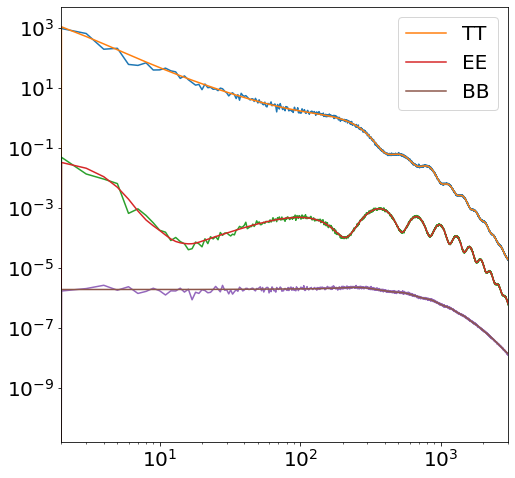

In [36]:
pl.figure(figsize=(8,8))
pl.loglog(TT)
pl.loglog(cl_len['tt'],label='TT')
pl.loglog(EE)
pl.loglog(cl_len['ee'],label='EE')
pl.loglog(BB)
pl.loglog(cl_len['bb'],label='BB')
pl.xticks(fontsize=20)
pl.yticks(fontsize=20)
pl.legend(fontsize=20)
pl.xlim(2,3000)

(2, 3000)

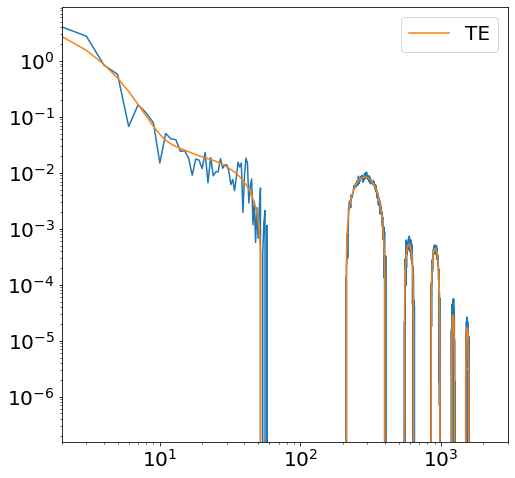

In [37]:
pl.figure(figsize=(8,8))
pl.loglog(TE)
pl.loglog(cl_len['te'],label='TE')
pl.xticks(fontsize=20)
pl.yticks(fontsize=20)
pl.legend(fontsize=20)
pl.xlim(2,3000)

In [25]:
cl_len.keys()

dict_keys(['tt', 'ee', 'bb', 'te'])